In [3]:
# Importación de librerias.
import pandas as pd
from gensim.models import KeyedVectors
import numpy as np
import matplotlib.pyplot as plt
from itertools import product


In [ ]:
hiperonimos_df = pd.read_csv('hiperonimos_animales.csv')
hiperonimos_df.head()

,palabra,hiperonimo
0,hormiga,insecto
1,castor,roedor
2,abeja,insecto
3,bufalo,bovino
4,mariposa,insecto


In [14]:
def crear_analogias(df):
    analogias = []
    
    # Se itera sobre cada elemento
    for i, (cueEjemplo, targetEjemplo) in df.iterrows():
        # Para cada cueEjemplo, se itera sobre todos los posibles cues
        for j, (cue, response) in df.iterrows():
            # Se permiten pares con el mismo hiperónimo
            if i != j:  # Evito usar la misma fila para cueEjemplo y cue
                analogias.append([cueEjemplo, targetEjemplo, cue, response])
    
    return pd.DataFrame(analogias, columns=['cueEjemplo', 'targetEjemplo', 'cue', 'response'])

# Generamos las analogías
analogias_animales_df = crear_analogias(hiperonimos_df)

# Definir la ruta del archivo CSV donde se guardarán las analogías
output_file_path = './analogias_animales.csv'

# Guardo el DataFrame en un archivo CSV
analogias_animales_df.to_csv(output_file_path, index=False)

analogias_animales_df.head()

,cueEjemplo,targetEjemplo,cue,response
0,hormiga,insecto,castor,roedor
1,hormiga,insecto,abeja,insecto
2,hormiga,insecto,bufalo,bovino
3,hormiga,insecto,mariposa,insecto
4,hormiga,insecto,gato,felino


In [13]:
embeddings_WIKI = KeyedVectors.load_word2vec_format('embeddings/wiki.es.vec', limit=None)
embeddings_SUC = KeyedVectors.load_word2vec_format('embeddings/embeddings-l-model.vec', limit=None)
embeddings_SWOW = KeyedVectors.load_word2vec_format('embeddings/swow.embedding.was.26-04-2022.vec', limit=None)
lower_embeddings_SWOW = KeyedVectors(vector_size=embeddings_SWOW.vector_size)
embeddings_SBWC = KeyedVectors.load_word2vec_format('embeddings/SBW-vectors-300-min5.txt', limit=None)
embeddings_Glove = KeyedVectors.load_word2vec_format('embeddings/glove-sbwc.i25.vec', limit=None)

In [16]:
# Embedding SWOW pasado a minusculas 

# Vectores y palabras del SWOW.
palabras = list(embeddings_SWOW.key_to_index.keys())
vectores = list(embeddings_SWOW.vectors)

# Convertir todas las palabras a minúsculas.
palabras_minusculas = [palabra.lower() for palabra in palabras]

# Creación de un nuevo modelo SWOW con las palabras y vectores en minúsculas. 
lower_embeddings_SWOW = KeyedVectors(vector_size=embeddings_SWOW.vector_size)
lower_embeddings_SWOW.add_vectors(palabras_minusculas, vectores)

In [17]:
lista_de_Embeddings_2 = [embeddings_WIKI, embeddings_SUC, lower_embeddings_SWOW, embeddings_SBWC, embeddings_Glove]

In [18]:
# Filtrar filas que tengan todas las palabras en todos los embeddings

# "all" combina los valores booleanos de word in e.key_to_index, para todos los embeddings e
# luego, se forma un valor para cada fila de cada una de las 4 columnas
columns = ['cueEjemplo', 'targetEjemplo','cue','response']
filtro = [ [ all(word in e.key_to_index  for e in lista_de_Embeddings_2) for word in analogias_animales_df[column]] for column in columns]
# me quedo sólo con las que tienen todas las palabras en todos los embeddings
filtro = [a & b & c & d for a,b,c,d in zip(filtro[0],filtro[1],filtro[2],filtro[3])]

analogias_animales_df = analogias_animales_df[filtro]

In [23]:
palabras_no_encontradas_2 = []  # lista que va a almacenar las palabras no encontradas

def calcular_predicciones_hiperonimos(embedding, analogias_animales_df, K_fijo):
    predicciones = []  # lista que va a almacenar las predicciones generadas
    for index, row in analogias_animales_df.iterrows():  # bucle que itera sobre las filas del df
        cueEjemplo = row['cueEjemplo']
        targetEjemplo = row['targetEjemplo']  # se extraen las palabras clave de la fila del dataframe
        cue = row['cue']

        try:
            resultado = embedding.most_similar(positive=[cueEjemplo, targetEjemplo, cue], topn=K_fijo)  # se obtienen las palabras más similares
            predicciones.append([palabra for palabra, _ in resultado])  # se agregan las palabras similares a la lista de predicciones
        except KeyError as e:  # excepción KeyError si alguna de las palabras no está presente en los embeddings
            print(f"Una de las palabras no está en el embedding: {e}")  # mensaje de advertencia
            predicciones.append([])  # se agrega una lista vacía a las predicciones
            palabras_no_encontradas_2.append(str(e).split("'")[1])  # se agrega la palabra no encontrada a la lista
    return predicciones  # devuelve la lista de predicciones

def metricas_topK_hiperonimos(predicciones, analogias_animales_df, K):
    analogias_animales_df['response'] = analogias_animales_df['response'].fillna('')  # se llenan los valores nulos en la columna 'response'
    analogias_animales_df['response'] = analogias_animales_df['response'].apply(lambda x: str(x))  # chequeamos de que todos los valores sean strings
    topK_metricas = []  # lista que va a almacenar las métricas calculadas
    for i, prediccion in enumerate(predicciones):  # bucle que itera sobre las predicciones
        respuesta_humana = analogias_animales_df.iloc[i]['response'].lower()  # se obtiene la respuesta humana para la analogía actual y se la convierte a minúsculas
        topK_metricas.append(int(respuesta_humana in prediccion[0:K]))  # se agrega 1 a la lista si la respuesta humana está en las predicciones, y 0 en caso contrario
    return np.mean(topK_metricas)  # devuelve el promedio de la lista topK_metricas, lo que representa la métrica final de precisión top-K

# Uso de las funciones con analogias_animales_df
# Tendrás que asegurarte de tener una instancia de 'embedding' apropiada creada antes de llamar a calcular_predicciones.
# predicciones = calcular_predicciones(tu_embedding, analogias_animales_df, K_fijo)
# precision_top_k = metricas_topK(predicciones, analogias_animales_df, K)

In [26]:
K_fijo = 25
todas_predicciones = [calcular_predicciones_hiperonimos(e, analogias_animales_df, K_fijo) for e in lista_de_Embeddings_2] 
# es una lista de listas, cada lista en todas_predicciones contiene las predicciones generadas para cada embedding en específico
# Se itera sobre cada modelo de embedding (e) en lista_de_Embeddings y se llama a la función calcular_predicciones con ese modelo, el df analogias_df y el valor de K_fijo
# Se generan predicciones para cada fila en analogias_df utilizando el embedding 

# en base aun únic cálculo de predicciones, calcular las métricas para diferentes valores de K
Ks = [5, 10, 15, 20, 25]
topK_metricas_hiperonimos = [[metricas_topK_hiperonimos(prediccion, analogias_animales_df,K)  for K in Ks] for prediccion in todas_predicciones]
# lista que almacena las métricas calculadas por metricas_topK para cada conjunto de predicciones en todas_predicciones
# Se itera sobre cada conjunto de predicciones en todas_predicciones y se llama a la función metricas_topK con ese conjunto de predicciones y el df analogias_df. 
# Se calcula la métrica de precisión top-K para cada conjunto de predicciones y devuelve una lista de estas métricas, cada valor representa la precisión top-K para un modelo de embedding específico
print(f"Métricas top-K ={Ks}: {topK_metricas_hiperonimos}")

Métricas top-K =[5, 10, 15, 20, 25]: [[0.01098901098901099, 0.016483516483516484, 0.016483516483516484, 0.016483516483516484, 0.016483516483516484], [0.027472527472527472, 0.03296703296703297, 0.04395604395604396, 0.04945054945054945, 0.06593406593406594], [0.0, 0.0, 0.016483516483516484, 0.06593406593406594, 0.11538461538461539], [0.0, 0.0, 0.0, 0.0, 0.0], [0.01098901098901099, 0.038461538461538464, 0.054945054945054944, 0.06043956043956044, 0.09340659340659341]]


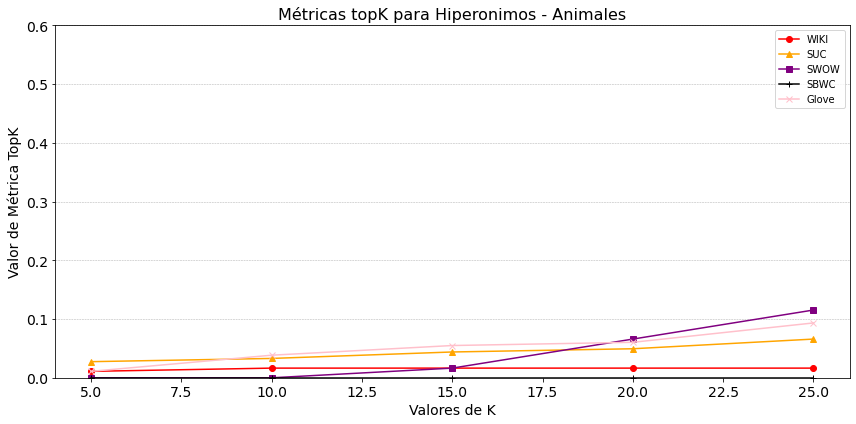

In [29]:
# Nombres de embeddings
lista_de_Nombres = ["WIKI", "SUC", "SWOW", "SBWC", "Glove"]

# Colores para plotear
colors = ['red', 'orange','purple', 'black', 'pink']


# marcadores para usar
markers = ['o', '^', 's','+','x']  # Markers for each category

# numero de embeddings
num_embeddings = len(lista_de_Nombres)

#width = 0.2

# Crear la figura para los datos del valor de K fijo
fig, ax = plt.subplots(figsize=(12, 6))

# valores de x para cada barra
x = np.arange(num_embeddings)

#bar = ax.bar(x, data_fijo, width, color='pink', edgecolor='black')
for i, emb in enumerate(lista_de_Nombres):
    plt.plot(Ks, topK_metricas_hiperonimos[i], color=colors[i], label=lista_de_Nombres[i],marker=markers[i])


# Etiquetas 
ax.set_xlabel('Valores de K', fontsize=14)
ax.set_ylabel('Valor de Métrica TopK', fontsize=14)
ax.set_title(f'Métricas topK para Hiperonimos - Animales', fontsize=16)
#ax.set_xticks(x)
#ax.set_xticklabels(lista_de_Nombres, rotation=45, fontsize=12)

# Limitar el eje y entre 0 y .6
ax.set_ylim([0, .6])

ax.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)
ax.tick_params(axis='both', labelsize=14)

plt.tight_layout()
plt.legend()
plt.show()